<a href="https://colab.research.google.com/github/Henchen99/BEng-Project/blob/main/VED/EVdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# pip install pmdarima

In [ ]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.style as style
from matplotlib import pyplot
from pandas.plotting import lag_plot

import datetime as dt
import matplotlib.dates as md
from datetime import date, time

import statsmodels as sm
import statsmodels.api as smapi
from statsmodels.tsa.seasonal import seasonal_decompose

# import warnings
# warnings.filterwarnings('ignore')

# from forecast_tools.baseline import Naive1, Drift, SNaive, Average, baseline_estimators
# from forecast_tools.metrics import coverage, mean_absolute_percentage_error

from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from math import sqrt

from sklearn.svm import SVR

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf

from statsmodels.tsa.arima.model import ARIMA
#from pmdarima import auto_arima

from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#housedata = pd.read_csv('CLEAN_House4_nov_2013.csv', parse_dates=True)
usecol = ['date','soc','latitude','longitude']
EVdata = pd.read_csv('/content/drive/MyDrive/forecasting/EV data from 4th to 13th november.csv', usecols = usecol, parse_dates=True)


In [ ]:
EVdate = EVdata['date']
soc = EVdata['soc']
EVdate=EVdate.apply(str)    #turn panda column into string
EVdate=EVdate.str.replace(' ','\n')
EVdate=pd.to_datetime(EVdate,dayfirst=True)


In [ ]:
EVdata

,date,soc,latitude,longitude
0,04/11/2017 00:00:00,48.9024,42.243933,83.743826
1,04/11/2017 00:00:01,48.9024,42.243933,83.743826
2,04/11/2017 00:00:02,48.9024,42.243933,83.743826
3,04/11/2017 00:00:03,48.9024,42.243933,83.743826
4,04/11/2017 00:00:04,48.9024,42.243933,83.743826
...,...,...,...,...
863583,13/11/2017 23:59:55,61.3415,42.253258,-83.728314
863584,13/11/2017 23:59:56,61.3415,42.253258,-83.728314
863585,13/11/2017 23:59:57,61.3415,42.253258,-83.728314
863586,13/11/2017 23:59:58,61.3415,42.253258,-83.728314


In [ ]:
# drop=258532
# EVdate = EVdate.drop(EVdate.index[drop:863589]) #4th to 7th
# soc = soc.drop(soc.index[drop:863589])

In [ ]:
frequencyEV = len(EVdate)/7
plt.figure(figsize=(15, 6))
#plt.xticks(np.arange(0,len(EVdate),frequencyEV),fontsize=15)    
plt.plot(EVdate,soc,linewidth=1)
plt.xlim(0)
plt.grid()
plt.show()

ValueError: ignored

Text(0.5, 1.0, 'State of Charge Profile')

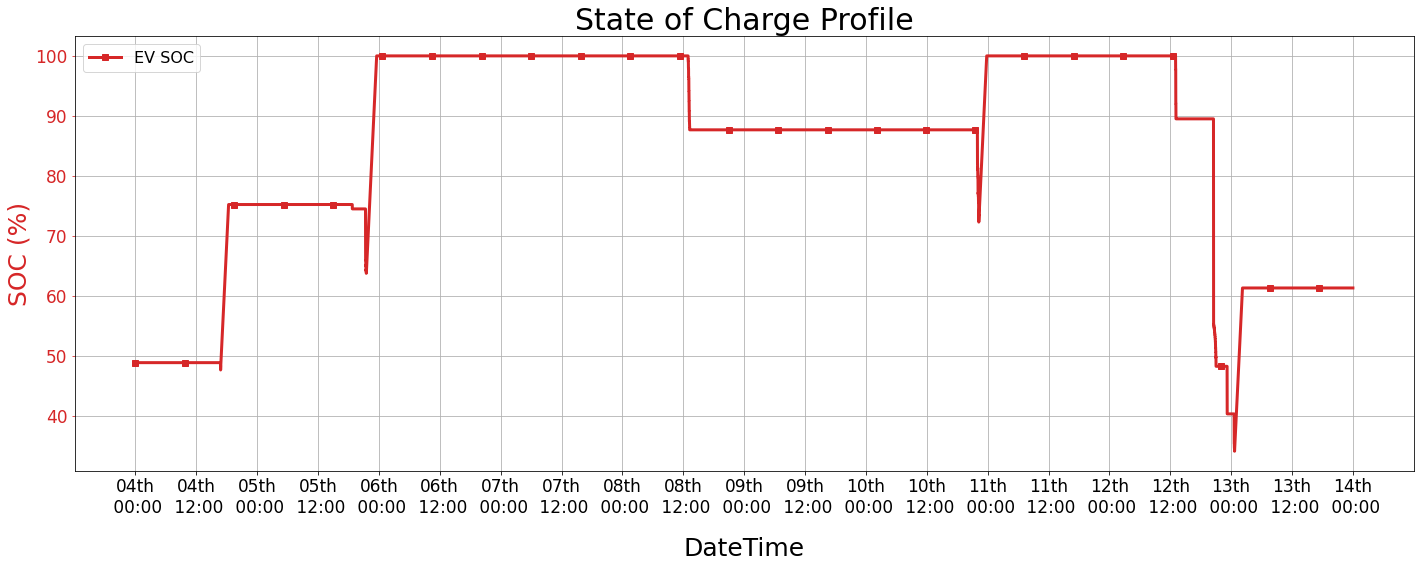

In [ ]:
fig=plt.figure(figsize=(24,8))
ax=fig.add_subplot(111, label="1")
# frequencyHouse = round(len(EVdata)/77)
# plt.xticks(np.arange(0,len(EVdata),frequencyHouse),fontsize=10)    

ax.plot(EVdate, soc, linewidth=3, color="C3", label='EV SOC', ls='-',marker='s',markevery=35000)
ax.set_xlabel("DateTime",fontsize=25)
ax.set_ylabel("SOC (%)",fontsize=25, color="C3")
#ax.axhline(300,color='limegreen',linewidth=1.5,label='Classifier Threshold')
ax.tick_params(axis='x',labelsize=17) #, rotation=45
ax.tick_params(axis='y', colors="C3",labelsize=17)
ax.xaxis.labelpad = 20
ax.grid()
#ax.get_xaxis().set_visible(False)

lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc=2, fontsize = 16)
ax.xaxis.set_major_locator(md.HourLocator(byhour=[0,12]))
ax.xaxis.set_major_formatter(md.DateFormatter("%dth\n %H:%M"))
#ax.xlim(left=0,right=0)
plt.title('State of Charge Profile',fontsize=30)
#plt.show()

# Stationarity

In [ ]:
soc = EVdata['soc']
soc

0         48.9024
1         48.9024
2         48.9024
3         48.9024
4         48.9024
           ...   
863583    61.3415
863584    61.3415
863585    61.3415
863586    61.3415
863587    61.3415
Name: soc, Length: 863588, dtype: float64

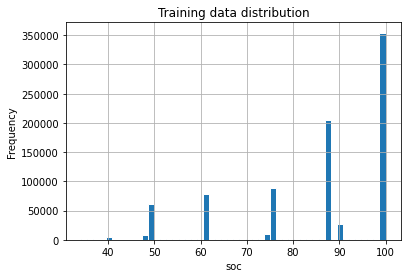

In [ ]:
ax=plt.hist(soc, bins=50, edgecolor='white', linewidth=1)
plt.title('Training data distribution')
plt.ylabel('Frequency')
plt.xlabel('soc');
plt.grid()

adfuller test

In [ ]:
def adfuller_test(soc):
    result=adfuller(soc)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [ ]:
adfuller_test(EVdata['soc'])

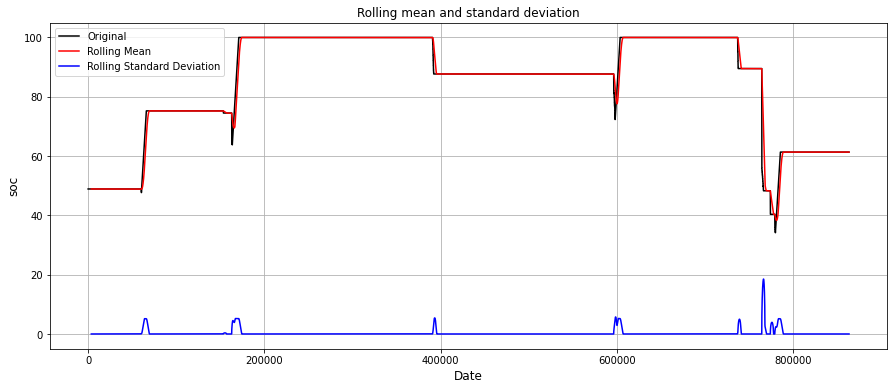

In [ ]:
rmean1=soc.rolling(window=3600).mean()
rstd1=soc.rolling(window=3600).std()
#print(rmean1,rstd1)
plt.figure(figsize=(15,6))
orig=plt.plot(soc , color='black',label='Original')
mean= plt.plot(rmean1 , color='red',label='Rolling Mean')
std=plt.plot(rstd1,color='blue',label = 'Rolling Standard Deviation')
plt.legend(loc='best')
plt.title("Rolling mean and standard deviation")
plt.ylabel("soc", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.grid()
plt.show(block=False)

# ARIMA

In [ ]:
data_length = EVdata.shape[0]
split70 = round(data_length*0.7)
train = EVdata.iloc[:split70]
test = EVdata.iloc[split70:]
print(train.shape, test.shape)
print(data_length)

(604512, 4) (259076, 4)
863588


In [ ]:
arimamodel = ARIMA(train['soc'], order=(1,0,1))
arimamodel = arimamodel.fit()
#arimamodel.summary()

In [ ]:
start = len(train)
end = len(train) + len(test) -1
arimapred = arimamodel.predict(start=start, end=end, typ='levels')
arimapred

In [ ]:
arimapred.plot(legend = True, figsize=(15,6))
plt.title('ARIMA forecast in 1 month March 2020', fontsize=12)
plt.ylabel("Price (p/kWh)", fontsize=12)
plt.xlabel("Date", fontsize=12)
test['soc'].plot(legend = True)
plt.grid()

# ARIMA Rolling

In [ ]:
EVdata

,date,soc,latitude,longitude
0,04/11/2017 00:00:00,48.9024,42.243933,83.743826
1,04/11/2017 00:00:01,48.9024,42.243933,83.743826
2,04/11/2017 00:00:02,48.9024,42.243933,83.743826
3,04/11/2017 00:00:03,48.9024,42.243933,83.743826
4,04/11/2017 00:00:04,48.9024,42.243933,83.743826
...,...,...,...,...
863583,13/11/2017 23:59:55,61.3415,42.253258,-83.728314
863584,13/11/2017 23:59:56,61.3415,42.253258,-83.728314
863585,13/11/2017 23:59:57,61.3415,42.253258,-83.728314
863586,13/11/2017 23:59:58,61.3415,42.253258,-83.728314


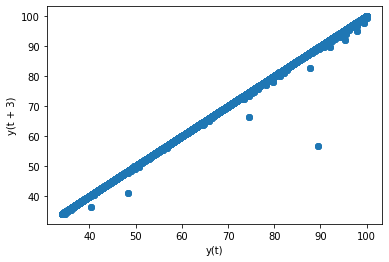

In [ ]:
plt.figure()
lag_plot(EVdata['soc'],lag=3)
plt.show()

In [ ]:
data_length = EVdata.shape[0]
split70 = round(data_length*0.7)
train_data = EVdata.iloc[:split70]
test_data = EVdata.iloc[split70:]

training_data = train_data['soc'].values  #take the price column values
test_data = test_data['soc'].values
history = [x for x in training_data]  #list comprehension to iterate through training_data
model_predictions = []  #instantiate empty list
N_test_observations = len(test_data)  
for t in range(N_test_observations):
    model = smapi.tsa.arima.ARIMA(history, order=(1,0,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[t]
    history.append(true_test_value)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: 

In [ ]:
test_set_range = EVdata[int(len(EVdata)*0.7):].index
#test_set_range = test_set_range[1:]
print(test_set_range)
test_set_range=test_set_range[1:]
plt.figure(figsize=(20,8))
# plt.plot(test_set_range, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, model_predictions, color='blue',label='Predicted Price')
plt.plot(test_set_range, test_data, color='red', label='Actual Price')
plt.title('Rolling ARIMA forecast TOU Prices Prediction',fontsize=20)
plt.xlabel('Date',fontsize=30)
plt.ylabel('Power',fontsize=30)
plt.tick_params(axis='y',labelsize=14)
plt.tick_params(axis='x',labelsize=14)
plt.legend(fontsize=15)
plt.grid()
plt.show()

In [ ]:
print("ARIMA Rolling RMSE: ", sqrt(mean_squared_error(model_predictions,test_data)))
print("ARIMA Rolling MSE: ", mean_squared_error(model_predictions, test_data))
print("ARIMA Rolling MAE: ", mean_absolute_error(model_predictions, test_data))
print("ARIMA Rolling R2 Score: ", r2_score(model_predictions, test_data))
print("R2 Score (Accuracy Metric): ", round(r2_score(model_predictions, test_data),3)*100,"%")
# print("Prophet Accuracy: ", score(forecast['yhat'], test['y']))